# PCA 2 (Core)
**Visualización de Datos con Componentes Principales**

**Descripción:**

En esta actividad, utilizarás el Análisis de Componentes Principales (PCA) para visualizar datos en un espacio de menor dimensionalidad. Trabajarás con el famoso dataset «Iris» para reducir sus características a dos componentes principales y visualizar cómo se distribuyen las diferentes clases en este nuevo espacio de características.

Enlace al dataset: https://www.kaggle.com/uciml/iris



## Objetivo:

El objetivo es reducir la dimensionalidad del dataset «Iris» mediante PCA, visualizando las clases en el nuevo espacio bidimensional y evaluando si los componentes principales son capaces de capturar adecuadamente la variabilidad de los datos.

In [1]:
# Agregar la carpeta 'src' al sys.path
import sys
import os

# Buscar 'src' automáticamente sin depender del nombre del proyecto
current_dir = os.getcwd()  # Directorio actual
while not os.path.exists(os.path.join(current_dir, "src")):
    current_dir = os.path.dirname(current_dir)  # Subir un nivel
    if current_dir == "/":  # Evitar bucles infinitos
        raise FileNotFoundError("No se encontró la carpeta 'src'. Verifica la estructura.")

src_path = os.path.join(current_dir, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from utils import cargar_datos_pd
from utils import dimensiones
from utils import ver_resumen_nulos
from utils import identificar_atipicos_IQR
from utils import ver_diccionario
from utils import imprimir_bigotes
from utils import plot_varianza
from utils import filtrar_columnas
from utils import desc
from utils import imprimir_bigotes_por_grupo

# 1. Carga de datos

In [2]:
df = cargar_datos_pd(ruta_archivo='../../data/Iris.csv',sep=',', header=0)

Dataset cargado con éxito.


In [3]:
dimensiones(df)

Dimensiones del dataset:
Features: 6, Ejemplos: 150
Primeras 5 filas del dataset:


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


# 2. Exploración y preprocesamiento de datos:
- Realiza una exploración inicial del dataset. Revisa los valores nulos, los rangos de las variables y cualquier valor atípico que pueda afectar el rendimiento de PCA.


In [4]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
Id,150,0,0.0
SepalLengthCm,150,0,0.0
SepalWidthCm,150,0,0.0
PetalLengthCm,150,0,0.0
PetalWidthCm,150,0,0.0
Species,150,0,0.0


No hay valores nulos.

In [5]:
# Identificar duplicados
duplicados = df[df.duplicated(keep=False)]

# Mostrar los duplicados encontrados
if not duplicados.empty:
    print("Duplicados eliminados:")
    print(duplicados)
else:
    print("No se encontraron duplicados para eliminar.")

# Eliminar duplicados
df = df.drop_duplicates()

No se encontraron duplicados para eliminar.


### Verificación y ajuste de tipos de datos

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


### **Corrección de inconsistencias en valores categóricos**

In [7]:
columna = 'Species'
df[columna].value_counts()

Species
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

La categorica Species tiene balanceo de clases.

#### Identificación de valores fuera de rango

In [8]:
# Generar el describe
df_describe = df.drop(columns=['Id']).describe().T  # Transponer para facilitar la manipulación

# Agregar columna del porcentaje de std sobre la media con redondeo a 2 decimales
df_describe['%std/mean'] = ((df_describe['std'] / df_describe['mean']) * 100).round(2)

# Mostrar el resultado
print(df_describe)



               count      mean       std  min  25%   50%  75%  max  %std/mean
SepalLengthCm  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9      14.17
SepalWidthCm   150.0  3.054000  0.433594  2.0  2.8  3.00  3.3  4.4      14.20
PetalLengthCm  150.0  3.758667  1.764420  1.0  1.6  4.35  5.1  6.9      46.94
PetalWidthCm   150.0  1.198667  0.763161  0.1  0.3  1.30  1.8  2.5      63.67


In [9]:
columnas = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
desc(df, columns=columnas)

,count,mean,std,min,25%,50%,75%,max,%std/mean
SepalLengthCm,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9,14.17
SepalWidthCm,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4,14.20
PetalLengthCm,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9,46.94
PetalWidthCm,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5,63.67


No veo valores ceros

Revisar la distribución

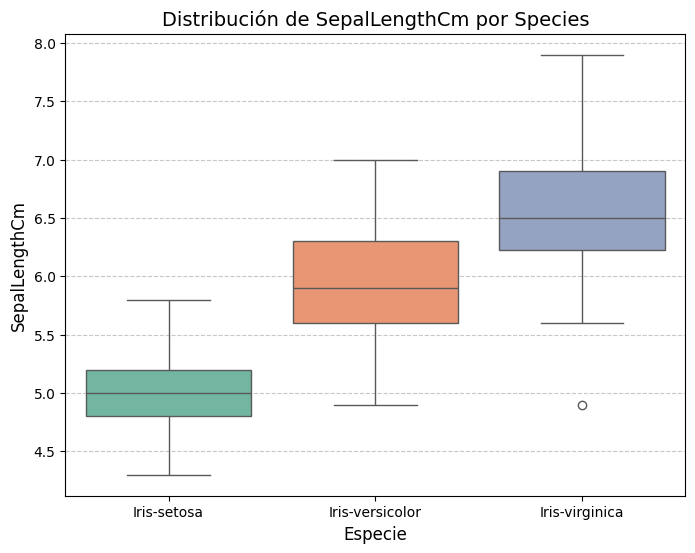

----------------------------------------------------------------------------------------------------
Descripción de SepalLengthCm por Species
Species  Iris-setosa  Iris-versicolor  Iris-virginica
count       50.00000        50.000000        50.00000
mean         5.00600         5.936000         6.58800
std          0.35249         0.516171         0.63588
min          4.30000         4.900000         4.90000
25%          4.80000         5.600000         6.22500
50%          5.00000         5.900000         6.50000
75%          5.20000         6.300000         6.90000
max          5.80000         7.000000         7.90000

Bigotes de SepalLengthCm por grupo:

Especie: Iris-setosa
Límite inferior (bigote inferior): 4.199999999999999
Límite superior (bigote superior): 5.800000000000001

Especie: Iris-versicolor
Límite inferior (bigote inferior): 4.549999999999999
Límite superior (bigote superior): 7.35

Especie: Iris-virginica
Límite inferior (bigote inferior): 5.212499999999999
Límite sup

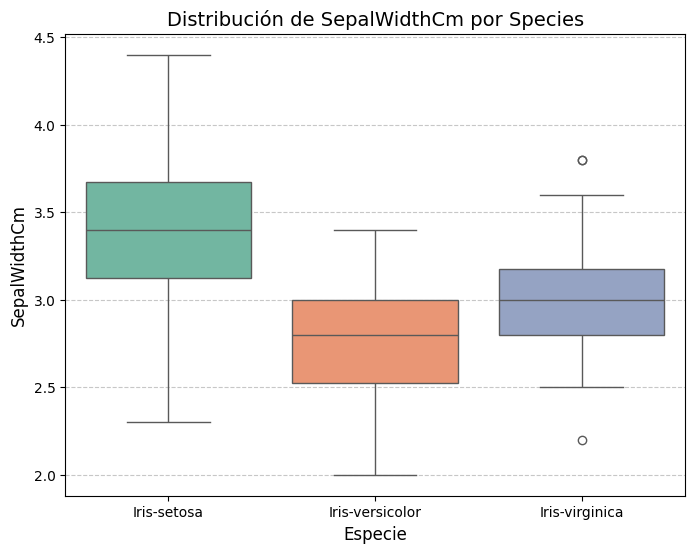

----------------------------------------------------------------------------------------------------
Descripción de SepalWidthCm por Species
Species  Iris-setosa  Iris-versicolor  Iris-virginica
count      50.000000        50.000000       50.000000
mean        3.418000         2.770000        2.974000
std         0.381024         0.313798        0.322497
min         2.300000         2.000000        2.200000
25%         3.125000         2.525000        2.800000
50%         3.400000         2.800000        3.000000
75%         3.675000         3.000000        3.175000
max         4.400000         3.400000        3.800000

Bigotes de SepalWidthCm por grupo:

Especie: Iris-setosa
Límite inferior (bigote inferior): 2.3
Límite superior (bigote superior): 4.500000000000001

Especie: Iris-versicolor
Límite inferior (bigote inferior): 1.8124999999999998
Límite superior (bigote superior): 3.7125000000000004

Especie: Iris-virginica
Límite inferior (bigote inferior): 2.237499999999999
Límite supe

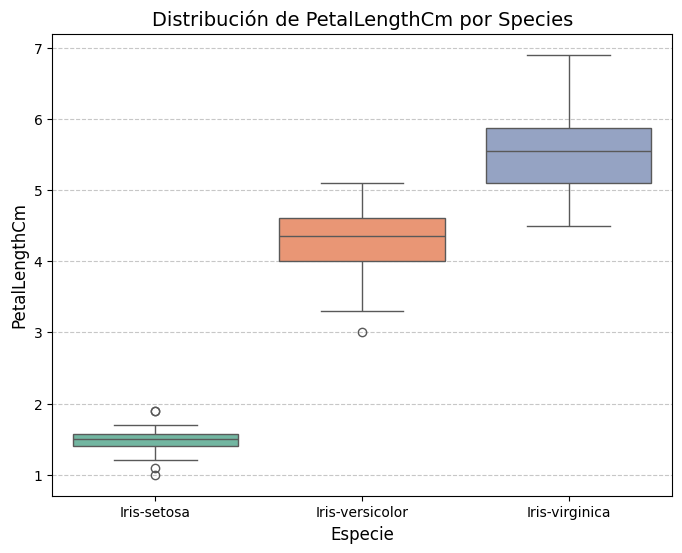

----------------------------------------------------------------------------------------------------
Descripción de PetalLengthCm por Species
Species  Iris-setosa  Iris-versicolor  Iris-virginica
count      50.000000        50.000000       50.000000
mean        1.464000         4.260000        5.552000
std         0.173511         0.469911        0.551895
min         1.000000         3.000000        4.500000
25%         1.400000         4.000000        5.100000
50%         1.500000         4.350000        5.550000
75%         1.575000         4.600000        5.875000
max         1.900000         5.100000        6.900000

Bigotes de PetalLengthCm por grupo:

Especie: Iris-setosa
Límite inferior (bigote inferior): 1.1374999999999995
Límite superior (bigote superior): 1.8375000000000006

Especie: Iris-versicolor
Límite inferior (bigote inferior): 3.1000000000000005
Límite superior (bigote superior): 5.499999999999999

Especie: Iris-virginica
Límite inferior (bigote inferior): 3.9374999999

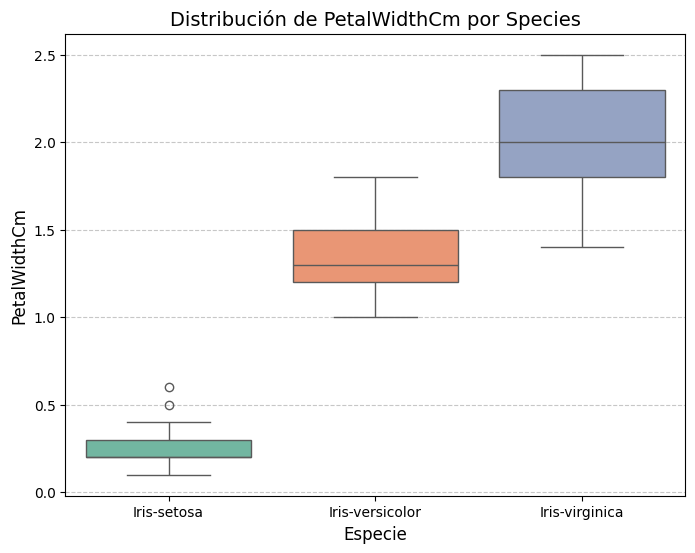

----------------------------------------------------------------------------------------------------
Descripción de PetalWidthCm por Species
Species  Iris-setosa  Iris-versicolor  Iris-virginica
count       50.00000        50.000000        50.00000
mean         0.24400         1.326000         2.02600
std          0.10721         0.197753         0.27465
min          0.10000         1.000000         1.40000
25%          0.20000         1.200000         1.80000
50%          0.20000         1.300000         2.00000
75%          0.30000         1.500000         2.30000
max          0.60000         1.800000         2.50000

Bigotes de PetalWidthCm por grupo:

Especie: Iris-setosa
Límite inferior (bigote inferior): 0.050000000000000044
Límite superior (bigote superior): 0.44999999999999996

Especie: Iris-versicolor
Límite inferior (bigote inferior): 0.7499999999999999
Límite superior (bigote superior): 1.9500000000000002

Especie: Iris-virginica
Límite inferior (bigote inferior): 1.05000000

In [10]:
target = 'Species'
for columna in df.drop(columns=['Id']):
    if columna != target:
        aux = df.loc[df[columna] > 0]
        
        # Crear el boxplot
        plt.figure(figsize=(8, 6))
        sns.boxplot(x=target, y=columna, hue=target, data=aux, palette='Set2')

        # Personalizar el gráfico
        plt.title(f'Distribución de {columna} por {target}', fontsize=14)
        plt.xlabel('Especie', fontsize=12)
        plt.ylabel(columna, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        print('-'*100)
        print(f'Descripción de {columna} por {target}')
        
        # Descripción estadística agrupada
        print(aux.groupby(by=target)[columna].describe().T)
        
        # Llamar a la nueva función para imprimir los bigotes
        imprimir_bigotes_por_grupo(aux, columna, target)
        
        print('-'*100)

print('-'*47,'FIN','-'*48)
print('-'*100,'\n')


- Normaliza las variables, ya que PCA es sensible a las escalas de las características. Esto asegura que las variables tengan una contribución equitativa en la formación de los componentes principales.

In [11]:
df.head(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Vamos a escalar los datos para tener media 0 y desviación estándar 1.
Porque veo que hay características que afectaran la varianza: La covarianza estará dominada por las características superiores intrudiendo sesgo en los componentes principales.

In [12]:
# Paso 1: Escalar los datos para tener media 0 y desviación estándar 1
# Define el objetivo y las características
target = 'Species'
X = df.drop(columns=[target, 'Id'])
y = df[target]

# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verifica las dimensiones
print(f"Tamaño de entrenamiento: {X_train_scaled.shape}, Tamaño de prueba: {X_test_scaled.shape}")


# Mostrar un resumen de los datos escalados
print("Resumen de datos escalados:")
print(f"Media por característica (aproximadamente 0): {X_train_scaled.mean(axis=0)[:5]}")
print(f"Desviación estándar por característica (aproximadamente 1): {X_train_scaled.std(axis=0)[:5]}")

Tamaño de entrenamiento: (105, 4), Tamaño de prueba: (45, 4)
Resumen de datos escalados:
Media por característica (aproximadamente 0): [ 3.67959631e-16  4.90678926e-18 -3.17206578e-17 -2.53765263e-17]
Desviación estándar por característica (aproximadamente 1): [1. 1. 1. 1.]


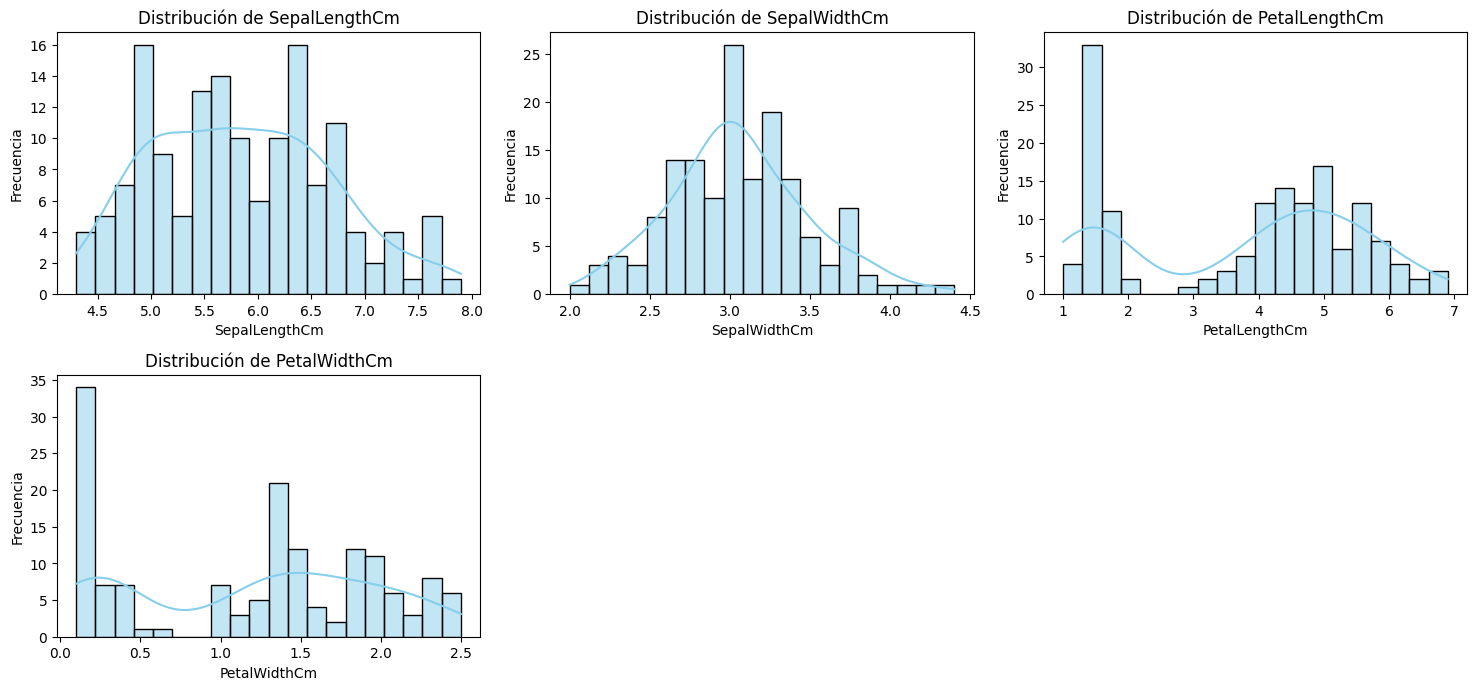

,count,mean,std,min,25%,50%,75%,max,%std/mean
SepalLengthCm,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9,14.17
SepalWidthCm,150.0,3.054000,0.433594,2.0,2.8,3.00,3.3,4.4,14.20
PetalLengthCm,150.0,3.758667,1.764420,1.0,1.6,4.35,5.1,6.9,46.94
PetalWidthCm,150.0,1.198667,0.763161,0.1,0.3,1.30,1.8,2.5,63.67


In [13]:
# Crear histogramas para todas las variables numéricas
def graficar_histogramas(df):
    # Seleccionar solo las columnas numéricas
    numericas = df.select_dtypes(include=['float64', 'int64']).columns
    
    plt.figure(figsize=(15, 10))
    for i, columna in enumerate(numericas, 1):
        plt.subplot(3, 3, i)  # Ajusta el tamaño de la cuadrícula de los subgráficos
        sns.histplot(df[columna], kde=True, bins=20, color='skyblue')
        plt.title(f'Distribución de {columna}')
        plt.xlabel(columna)
        plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()

# Llamar a la función
graficar_histogramas(df.drop(columns=['Id',target]))
#df.drop(columns=['Id',target]).describe().T
desc(df.drop(columns=['Id',target]))


# 3. Aplicación de PCA:

- Implementa PCA para reducir las cuatro dimensiones del dataset «Iris» a solo dos componentes principales.

In [25]:
# Paso 2: Aplicar PCA
pca = PCA(n_components=None)# Con None el grafico se genera con todos los componentes y se ve mejor.
pca.fit(X_train_scaled)# Aplicar PCA al dataset escalado
X_pca = pca.transform(X_train_scaled)

# Paso 3: Determinar cuántos componentes principales se necesitan para capturar al menos el 90% de la variabilidad
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Encontrar el número de componentes necesarios para capturar el 90% de la varianza
num_components = (cumulative_variance >= 0.90).argmax() + 1  # +1 porque los índices son base 0

# Mostrar el número de componentes y la varianza acumulada
print(f"Se necesitan {num_components} componentes para capturar al menos el 90% de la variabilidad.")
print(f"Varianza acumulada: {cumulative_variance[num_components - 1]:.4f}")

Se necesitan 2 componentes para capturar al menos el 90% de la variabilidad.
Varianza acumulada: 0.9519


- Visualiza el gráfico de «explained variance» para mostrar cómo cada componente principal contribuye a la variabilidad total de los datos.
- Calcula la «explained variance» para estos dos componentes y discute qué porcentaje de la variabilidad total de los datos está capturada en el espacio bidimensional.

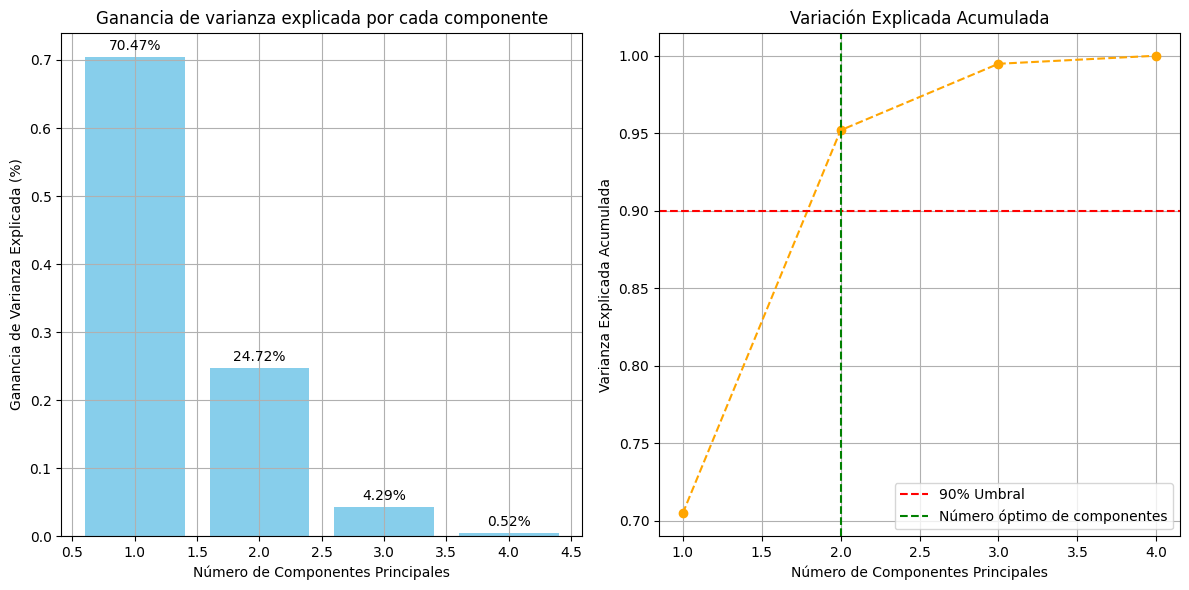

Variación explicada acumulada y ganancia:
Componente 1: 70.47% (70.47%)
Componente 2: 95.19% (24.72%)
Componente 3: 99.48% (4.29%)
Componente 4: 100.00% (0.52%)


In [26]:
plot_varianza(pca)

In [16]:

# Porcentaje capturado por los dos primeros componentes
varianza_dos_componentes = pca.explained_variance_ratio_[:2].sum()
print(f"\nLos dos primeros componentes capturan el {varianza_dos_componentes:.2%} de la variabilidad total.")


Los dos primeros componentes capturan el 95.19% de la variabilidad total.


Al observar que los **DOS** primeros componentes explican más del 95% de la variabilidad, se concluye que es viable realizar una representación en 2D.

In [31]:
numero_componentes = 2
# Paso 2: Aplicar PCA
pca = PCA(n_components=numero_componentes)# Con None el grafico se genera con todos los componentes y se ve mejor.
pca.fit(X_train_scaled)# Aplicar PCA al dataset escalado
X_pca = pca.transform(X_train_scaled)

# Paso 3: Determinar cuántos componentes principales se necesitan para capturar al menos el 90% de la variabilidad
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Encontrar el número de componentes necesarios para capturar el 90% de la varianza
num_components = (cumulative_variance >= 0.90).argmax() + 1  # +1 porque los índices son base 0

# Mostrar el número de componentes y la varianza acumulada
print(f"Se necesitan {num_components} componentes para capturar al menos el 90% de la variabilidad.")
print(f"Varianza acumulada: {cumulative_variance[num_components - 1]:.4f}")

Se necesitan 2 componentes para capturar al menos el 90% de la variabilidad.
Varianza acumulada: 0.9519


# 4. Visualización de los componentes principales:
- Proyecta los datos en el espacio bidimensional formado por los dos primeros componentes principales.
- Utiliza diferentes colores para representar cada una de las tres clases de flores en el gráfico y observa cómo se agrupan las clases en el espacio de los componentes principales.

In [32]:
# Crear un DataFrame con los coeficientes
componentes_df = pd.DataFrame(
    data=np.abs(pca.components_),  # Usamos el valor absoluto para interpretar magnitudes
    columns=X.columns,            # Nombres de las variables originales
    index=[f'PC{i+1}' for i in range(pca.n_components_)]  # Nombres de los componentes principales
)

# Mostrar los primeros componentes principales
print(componentes_df)

     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
PC1       0.535140      0.191236       0.590859      0.572661
PC2       0.317047      0.947645       0.014550      0.035198


In [33]:
# Ordenar las variables más influyentes por componente principal
for pc in componentes_df.index:
    print(f"\nVariables más influyentes en {pc}:")
    print(componentes_df.loc[pc].sort_values(ascending=False).head(5))


Variables más influyentes en PC1:
PetalLengthCm    0.590859
PetalWidthCm     0.572661
SepalLengthCm    0.535140
SepalWidthCm     0.191236
Name: PC1, dtype: float64

Variables más influyentes en PC2:
SepalWidthCm     0.947645
SepalLengthCm    0.317047
PetalWidthCm     0.035198
PetalLengthCm    0.014550
Name: PC2, dtype: float64


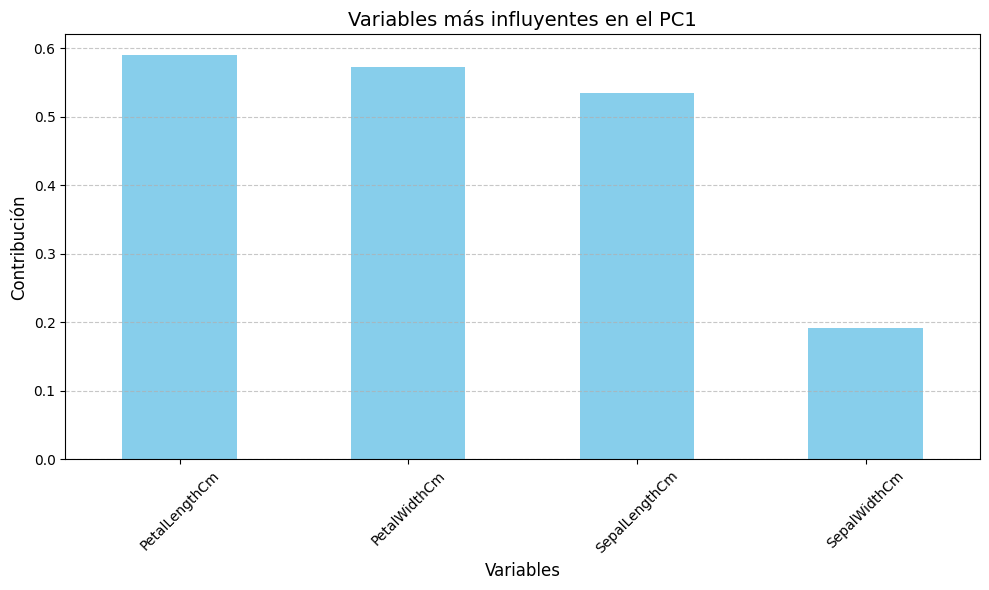

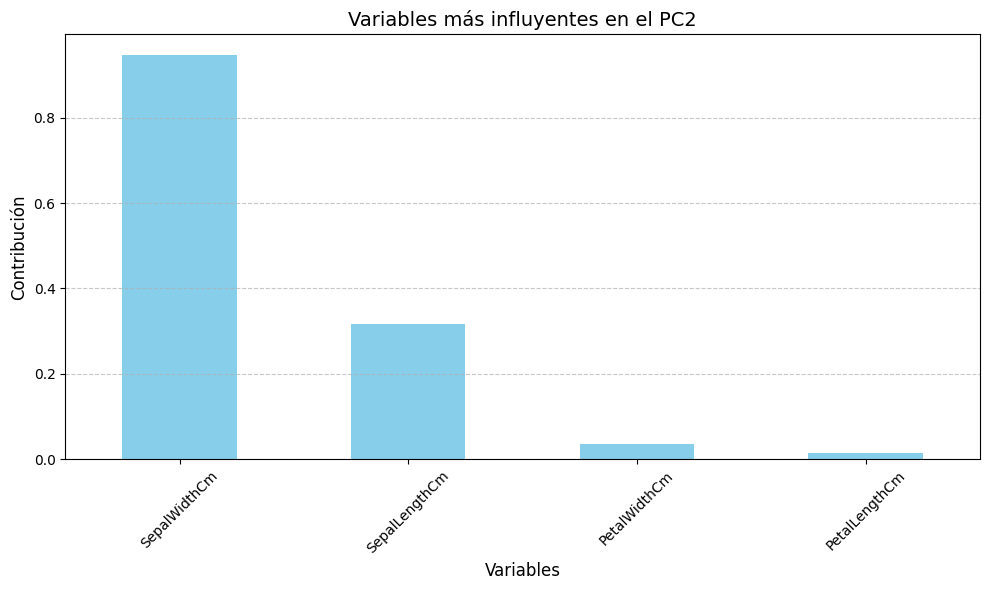

In [39]:
# Graficar las variables más influyentes por componente principal
for pc in componentes_df.index:
    # Graficar las variables más influyentes del primer componente
    plt.figure(figsize=(10, 6))
    componentes_df.loc[pc].sort_values(ascending=False).head(10).plot(kind='bar', color='skyblue')
    plt.title(f'Variables más influyentes en el {pc}', fontsize=14)
    plt.xlabel('Variables', fontsize=12)
    plt.ylabel('Contribución', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()   

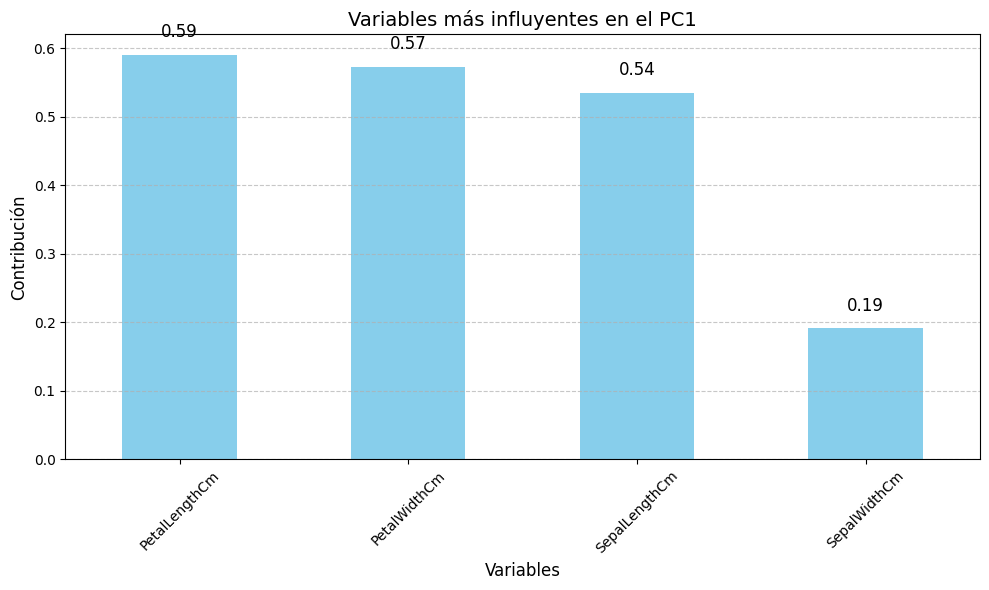

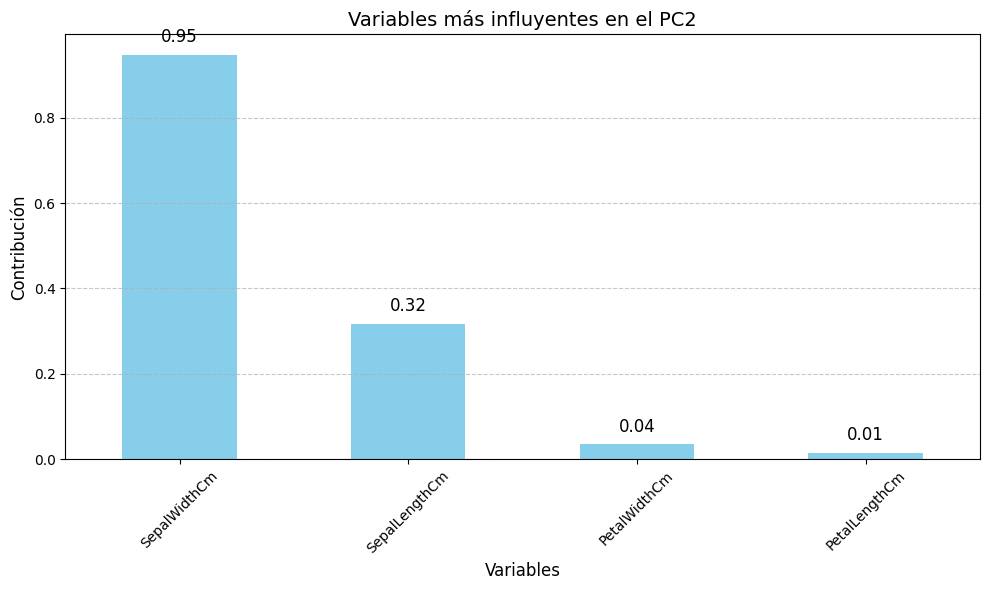

In [38]:
for pc in componentes_df.index:
    # Graficar las variables más influyentes del componente principal
    plt.figure(figsize=(10, 6))
    sorted_coefficients = componentes_df.loc[pc].sort_values(ascending=False).head(10)
    ax = sorted_coefficients.plot(kind='bar', color='skyblue')
    
    # Agregar los coeficientes sobre las barras
    for i, v in enumerate(sorted_coefficients):
        ax.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom', fontsize=12)  # Ajusta el valor de 0.02 si es necesario para separar el texto

    # Personalizar el gráfico
    plt.title(f'Variables más influyentes en el {pc}', fontsize=14)
    plt.xlabel('Variables', fontsize=12)
    plt.ylabel('Contribución', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

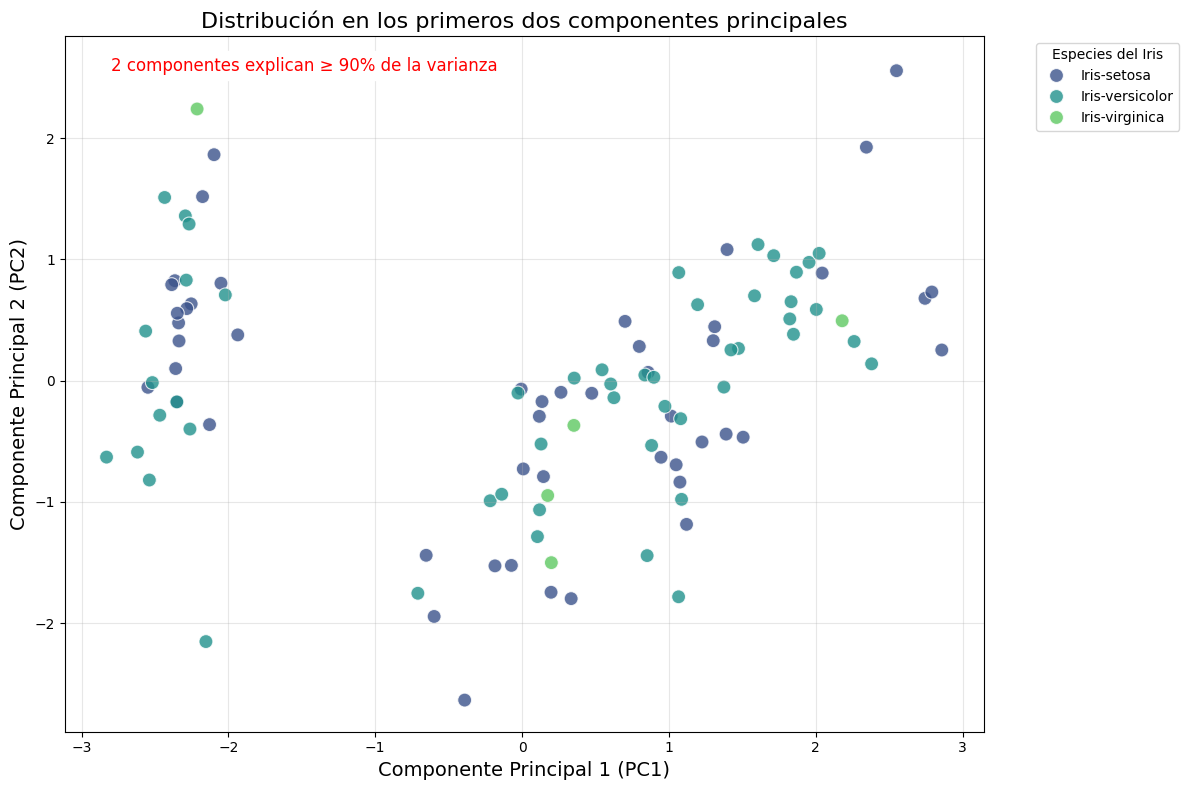

In [47]:
# Proyectar los datos en los dos primeros componentes principales
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df[target] = y.reset_index(drop=True)  # Asegurarse de que las etiquetas estén alineadas

# Visualización de los datos en el espacio de los primeros dos componentes principales
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue=target, 
    palette='viridis', alpha=0.8, s=100
)

# Agregar una anotación sobre el número de componentes necesarios
num_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.90) + 1  # +1 por índice base 0
plt.annotate(
    f"{num_components} componentes explican ≥ 90% de la varianza",
    xy=(0.05, 0.95), xycoords="axes fraction",
    fontsize=12, color="red", backgroundcolor="white"
)

# Personalizar el gráfico
plt.title('Distribución en los primeros dos componentes principales', fontsize=16)
plt.xlabel('Componente Principal 1 (PC1)', fontsize=14)
plt.ylabel('Componente Principal 2 (PC2)', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(title='Especies del Iris', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# 5. Interpretación de los resultados:
- Analiza los coeficientes de los dos componentes principales y explica qué variables tienen la mayor influencia en estos.
- Discute si PCA es capaz de separar correctamente las clases y cómo este análisis puede mejorar la comprensión de los datos.

In [23]:
# Modelo sin PCA
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Clasificación sin PCA:")
print(classification_report(y_test, y_pred))

# Aplicar PCA y entrenar el modelo
pca = PCA(n_components=2)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

model.fit(X_pca_train, y_train)
y_pred_pca = model.predict(X_pca_test)
print("Clasificación con PCA:")
print(classification_report(y_test, y_pred_pca))

Clasificación sin PCA:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45

Clasificación con PCA:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45



In [24]:
# Vamos a aplicar el PCA a nuestros datos de entrenamiento y prueba
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)
model = RandomForestClassifier()
model.fit(X_pca_train, y_train)
y_pred_pca = model.predict(X_pca_test)
print("Clasificación con PCA:")
print(classification_report(y_test, y_pred_pca))

Clasificación con PCA:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        19
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        45
      macro avg       1.00      1.00      1.00        45
   weighted avg       1.00      1.00      1.00        45



| **Variables/ Componentes Principales** | **Coeficientes** |      |
|:--------------------------------------:|:----------------:|:--------:|
|   Total Varianza explicada 95.19%      | **PC1 (70.47%)** | **PC2 (24.72%)** |
| PetalLengthCm                          | 0.590859         | 0.014550 |
| PetalWidthCm                           | 0.572661         | 0.035198 |
| SepalLengthCm                          | 0.535140         | 0.317047 |
| SepalWidthCm                           | 0.191236         | **0.947645** |


El Componente Principal 1 explica el 70.47% de la variabilidad de los datos y las 3 variables: PetalLength, PetalWidth y SepalLength tienen casi el mismo peso excepto la de SepalWidthCM pero es muy notorio que esta tiene un peso FUNDAMENTAL en el Componente Principal 2, que explica el 24.72% de la variabilidad. 

El SepalLengthCM tiene un peso importante tanto en ambos componentes principales. Teniendo en cuenta, es una variable muy importante en ambos componentes.

# Conclusión:

- Sin PCA: Se obtiene una clasificación utilizando todas las características.
- Con PCA: Se reduce la dimensionalidad y se utiliza solo la información más relevante de los componentes principales, lo que a veces mejora el rendimiento de los modelos y facilita la interpretación visual.  